In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
np.random.seed(10)
random_dim = 100

In [4]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
  (x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
  x_train = x_train.reshape((-1,28,28,1)).astype('float32')
  x_test = x_test.reshape((-1,28,28,1)).astype('float32')
  return (x_train, y_train, x_test, y_test)

In [5]:
x_train, y_train, _ , _ = load_mnist()

BATCH_SIZE = 256
BUFFER_SIZE = x_train.shape[0]
print(BUFFER_SIZE)

11493376/11490434 [==============================] - 0s 0us/step
60000


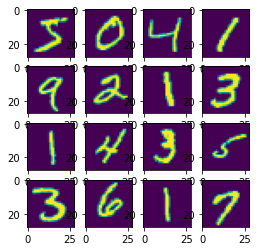

In [6]:
def plot_image(images, rows, cols):
  w=10
  h=10
  fig=plt.figure(figsize=(4, 4))
  for i in range(1, cols*rows +1):
      img = images[i-1]
      fig.add_subplot(rows, cols, i)
      plt.imshow(img.reshape((28,28)))
  plt.show()

samples = x_train[:4*4]
plot_image(samples,4,4)

In [7]:
# Build a generator
def define_generator(latent_dim = 100):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=latent_dim))
    model.add(tf.keras.layers.Reshape((7,7,128)))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))
    return model
g_model = define_generator()
g_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        7

In [8]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3),2,input_shape=(28,28,1),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model
d_model = build_discriminator()
d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [9]:
# Build GAN
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

d_model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# define GAN input
z = tf.keras.Input(shape=(100,))
img = g_model(z)

d_model.trainable = False
valid = d_model(img)

combined = tf.keras.Model(z,valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1625473   
Total params: 2,481,666
Trainable params: 855,809
Non-trainable params: 1,625,857
_________________________________________________________________


(60000, 28, 28, 1)
Losses(d,g): 0.7343471 0.5479833


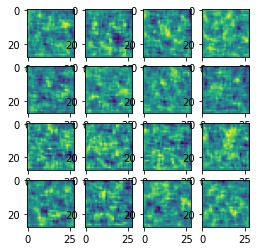

Losses(d,g): 0.67372614 0.7212534


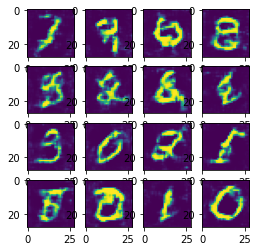

Losses(d,g): 0.6942166 0.73856944


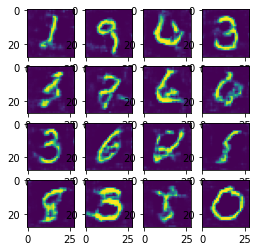

Losses(d,g): 0.67579895 0.8050356


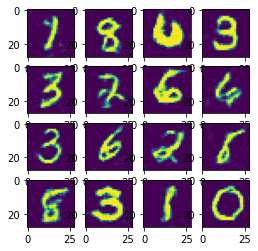

Losses(d,g): 0.6766226 0.7893989


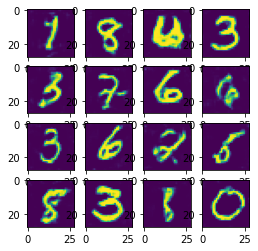

Losses(d,g): 0.6854079 0.77481616


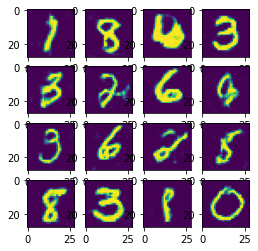

Losses(d,g): 0.67535365 0.80045533


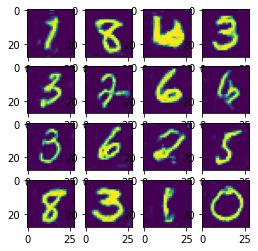

Losses(d,g): 0.6844794 0.7680226


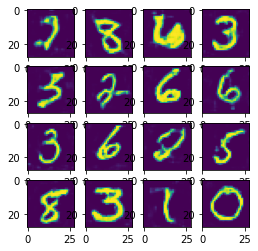

Losses(d,g): 0.67593765 0.80928624


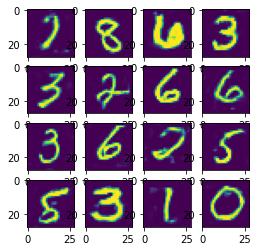

Losses(d,g): 0.6760737 0.7690508


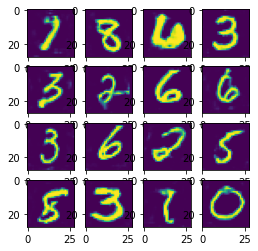

In [10]:
import os 

epochs = 10000
batch_size = 128
save_interval = 1000

print(x_train.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

samples = np.random.normal(0,1,(16, 100))

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    noise = np.random.normal(0,1,(batch_size, 100))
    fake_imgs = g_model.predict(noise)
    
    # train discriminator
    d_model.trainable = True
    d_loss_real = d_model.train_on_batch(real_imgs, valid)
    d_loss_fake = d_model.train_on_batch(fake_imgs, fake)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_model.trainable = False

    # train generator
    g_loss = combined.train_on_batch(noise, valid)
    
    if epoch % save_interval == 0:
        print("Losses(d,g):", d_loss[0], g_loss)
        results = g_model.predict(samples)
        plot_image(results, 4, 4)

In [11]:
g_model.save('generator.h5')
d_model.save('generator.h5')
combined.save('generator.h5')